In [1]:
%matplotlib nbagg
import gym
import gym.spaces
import gym.wrappers
import torch
import torch.nn
import torch.optim
import torch.distributions
import matplotlib.pyplot as plt

In [2]:
class LinearPolicy(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env

    def __new__(cls, env, *args, **kwargs):
        if isinstance(env.action_space, gym.spaces.Box):
            return ContinuousActionLinearPolicy(env, *args, **kwargs)
        elif isinstance(env.action_space, gym.spaces.Discrete):
            return DiscreteActionLinearPolicy(env, *args, **kwargs)


class DiscreteActionLinearPolicy(torch.nn.Module):
    def __init__(self, env):
        assert isinstance(env.action_space, gym.spaces.Discrete)
        assert isinstance(env.observation_space, gym.spaces.Box)
        super().__init__()
        self.linear = torch.nn.Linear(env.observation_space.shape[0], env.action_space.n)

    def forward(self, observation):
        probs = self.linear(torch.tensor(observation, dtype=torch.float32))
        action = probs.argmax()
        return action.detach().numpy()


class ContinuousActionLinearPolicy(torch.nn.Module):
    def __init__(self, env):
        assert isinstance(env.action_space, gym.spaces.Box)
        assert isinstance(env.observation_space, gym.spaces.Box)
        super().__init__()
        self.linear = torch.nn.Linear(env.observation_space.shape[0], env.action_space.shape[0])

    def forward(self, observation):
        action = self.linear(torch.tensor(observation, dtype=torch.float32))
        return action.detach().numpy()

In [3]:
class CrossEntropyMethod(torch.optim.Optimizer):
    def __init__(self, params, batch_size=25, elite_frac=0.20):
        defaults = {'batch_size': batch_size, 'elite_frac': elite_frac}
        super().__init__(params, defaults)
        self.batch_size = batch_size
        self.elite_frac = elite_frac
        self.loss = 0.0

        for ig, group in enumerate(self.param_groups):
            group['gaussians'] = []
            for ip, param in enumerate(group['params']):
                loc = torch.zeros_like(param.view(-1))
                covariance_matrix = torch.diag(torch.ones_like(param.view(-1)))
                group['gaussians'].append(torch.distributions.MultivariateNormal(loc, covariance_matrix))

    def step(self, closure):
        if closure is None:
            raise RuntimeError("CrossEntropyMethod optimizer requires closure that returns reward")

        candidates, rewards = [], []
        for i in range(self.batch_size):
            candidates.append({})
            for ig, group in enumerate(self.param_groups):
                for ip, (param, gaussian) in enumerate(zip(group['params'], group['gaussians'])):
                    sample = gaussian.sample()
                    candidates[i][ig, ip] = sample
                    param.data = sample.view(param.shape)
            rewards.append(float(closure()))

        elite_num = int(self.elite_frac * self.batch_size)
        elite_rewards_candidates = sorted(zip(rewards, candidates), key=lambda r_c: r_c[0])
        elite_rewards, elite_candidates = zip(*elite_rewards_candidates[:elite_num])

        for ig, group in enumerate(self.param_groups):
            for ip, (param, gaussian) in enumerate(zip(group['params'], group['gaussians'])):
                elite_params = torch.stack([elite_candidates[i][ig, ip] for i in range(elite_num)])
                loc = torch.mean(elite_params, dim=0, keepdim=True)
                covariance_matrix = torch.diag(torch.std(elite_params, dim=0, keepdim=True).view(-1))
                gaussian.loc, gaussian.covariance_matrix = loc, covariance_matrix
                param.data = loc.view(param.shape)

In [4]:
class TrainingMonitor:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
        self.rewards = env.stats_recorder.episode_rewards
        self.mean_rewards = []
        self.figure, self.axis = plt.figure(), plt.gca()

        self.axis.set_title('Training Monitor')
        self.axis.set_ylabel('Reward')
        self.axis.plot([], [], 'go', label='Episode Reward')
        self.axis.plot([], [], 'g', label='Mean Reward (50)')

    def plot(self):
        self.episodes = range(len(self.rewards))
        self.mean_rewards.append(sum(self.rewards[-50:])/50)

        self.axis.lines[0].set_xdata(self.episodes)
        self.axis.lines[0].set_ydata(self.rewards)
        self.axis.lines[1].set_xdata(self.episodes)
        self.axis.lines[1].set_ydata(self.mean_rewards)
        self.axis.relim()
        self.axis.autoscale_view()

        self.figure.canvas.draw()
        plt.pause(0.001)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


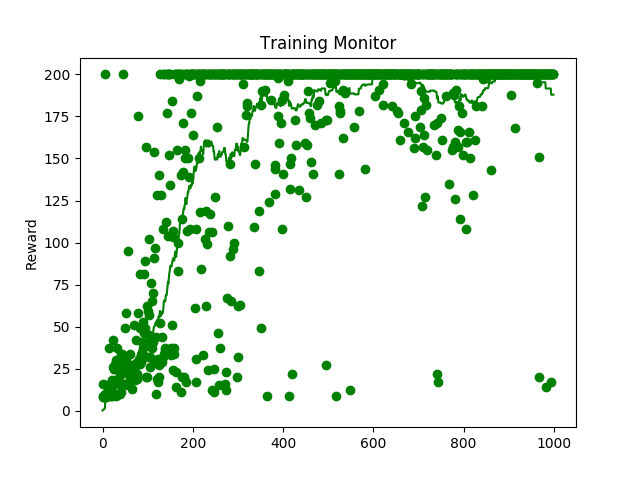

In [5]:
env = gym.make('CartPole-v0')  # Pendulum-v0
env = gym.wrappers.Monitor(env, directory='monitor', force=True)
policy = LinearPolicy(env)
optimizer = CrossEntropyMethod(policy.parameters(), batch_size=20, elite_frac=0.20)
monitor = TrainingMonitor(env, policy)


def run_episode(env, policy, render=False):
    observation, done, reward_sum = env.reset(), False, 0.0
    while not done:
        action = policy(observation)
        observation, reward, done, _ = env.step(action)
        reward_sum += reward
        if render: env.render()
    monitor.plot()
    return - torch.tensor(reward_sum)


for iteration in range(50):
    optimizer.step(lambda: run_episode(env, policy))